<a href="https://colab.research.google.com/github/namwootree/Portfolio/blob/main/Competition/Kaggle/Scrabble%20Player%20Rating/LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

## Install

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 46.0 MB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 78 kB 4.2 MB/s 
     |████████████████████████████████| 147 kB 51.4 MB/s 
     |████████████████████████████████| 50 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 30.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8c29b75e5c2e0cd044fa9e60d5d0e2cf65bc6a758edd0b60be6fd68cab5b06f3
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


## Library

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import os

from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, GroupKFold

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# Load Data Set

## Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Train / Test Set

In [89]:
X = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/y_train.csv')
y = y['rating']
X_test = pd.read_csv('/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/data/X_test.csv')

# Modeling

## Optuna

In [90]:
groups = X.pop('nickname')

def objective(trial, X, y):
    
    # 적용(수색)할 최적의 하이퍼 파라미터 범위 지정
    param = {
        "objective": "regression",
        "verbosity": -1,
        'learing_rate': trial.suggest_loguniform('learing_rate', 0.033, 0.1),
        'max_depth': trial.suggest_int('max_depth', 8, 25),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.03, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.03, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 128),
    }
    
    # LGBM reg 모델 사용 / 교차 검증 사용
    folds = GroupKFold(n_splits=5).split(X, y, groups=groups)

    lgbcv = lgb.cv(param,
                   lgb.Dataset(X, label=y),
                   folds= folds,
                   verbose_eval=100,                   
                   early_stopping_rounds=100,                   
                   num_boost_round=50000,
                   metrics = 'rmse',
                  )
    
    cv_score = lgbcv['rmse-mean'][-1]
    
    # Return metric of interest
    return cv_score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X, y),
               timeout=5000,
               n_trials=200,
               n_jobs=1,
               show_progress_bar=True) 

  0%|          | 0/200 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 125.354 + 37.9295
[200]	cv_agg's rmse: 123.794 + 33.328
[300]	cv_agg's rmse: 123.551 + 32.8181
[400]	cv_agg's rmse: 123.5 + 32.522
[100]	cv_agg's rmse: 117.084 + 18.8977
[200]	cv_agg's rmse: 118.003 + 18.4204
[100]	cv_agg's rmse: 139.128 + 55.4242
[200]	cv_agg's rmse: 135.554 + 49.2572
[300]	cv_agg's rmse: 135.181 + 47.7368
[100]	cv_agg's rmse: 106.93 + 10.2197
[100]	cv_agg's rmse: 122.471 + 25.7171
[100]	cv_agg's rmse: 106.987 + 12.3944
[200]	cv_agg's rmse: 108.584 + 12.9009
[100]	cv_agg's rmse: 135.858 + 45.4488
[200]	cv_agg's rmse: 132.28 + 39.508
[300]	cv_agg's rmse: 130.298 + 36.3241
[100]	cv_agg's rmse: 124.438 + 28.8323
[200]	cv_agg's rmse: 122.852 + 23.3029
[300]	cv_agg's rmse: 121.875 + 20.5007
[100]	cv_agg's rmse: 121.861 + 25.2352
[200]	cv_agg's rmse: 119.624 + 17.8094
[300]	cv_agg's rmse: 117.896 + 12.6386
[400]	cv_agg's rmse: 121.032 + 12.8435
[100]	cv_agg's rmse: 118.55 + 18.591
[100]	cv_agg's rmse: 123.37 + 27.6895
[200]	cv_agg's rmse: 119.957 + 23.4

In [ ]:
print(study.best_params)

In [ ]:
print(study.best_value)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

## Group KFold

In [58]:
preds = []

test_groups = X_test.pop('nickname') 

num_fold = 0

for repeat in range(3):

  skf = GroupKFold(n_splits=5)

  for fold_idx, (train_index, valid_index) in enumerate(tqdm(skf.split(X, y, groups=groups))):
      X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
      y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

      lgb_params = {
          'objective': 'regression',
          'verbose': 100,
          'n_estimators': 50000,
          **study.best_params
      }

      print(f'\nNumber fold : {num_fold}\n')

      model = LGBMRegressor(**lgb_params)

      model.fit(
                X = X_train, y = y_train,
                eval_set=(X_valid, y_valid),
                eval_metric = 'rmse',
                verbose=100,
                early_stopping_rounds=100
                )

      y_pred = model.predict(X_valid)

      score = mean_squared_error(y_valid, y_pred, squared=False)

      print("\nFold {} MSE Score: {}\n".format(fold_idx, score))
      print("\n----------------------\n")

      preds.append(model.predict(X_test))

      num_fold += 1

0it [00:00, ?it/s]


Number fold : 0

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 170.346	valid_0's l2: 29017.7
Early stopping, best iteration is:
[52]	valid_0's rmse: 165.185	valid_0's l2: 27286

Fold 0 MSE Score: 165.18485758470115


----------------------


Number fold : 1

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 112.23	valid_0's l2: 12595.6
Early stopping, best iteration is:
[28]	valid_0's rmse: 111.635	valid_0's l2: 12462.5

Fold 1 MSE Score: 111.63547694171369


----------------------


Number fold : 2

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 113.279	valid_0's l2: 12832.1
[200]	valid_0's rmse: 114.17	valid_0's l2: 13034.9
Early stopping, best iteration is:
[105]	valid_0's rmse: 112.695	valid_0's l2: 12700.2

Fold 2 MSE Score: 112.69522649101017


----------------------


Number fold : 3

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse:

0it [00:00, ?it/s]


Number fold : 5

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 170.346	valid_0's l2: 29017.7
Early stopping, best iteration is:
[52]	valid_0's rmse: 165.185	valid_0's l2: 27286

Fold 0 MSE Score: 165.18485758470115


----------------------


Number fold : 6

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 112.23	valid_0's l2: 12595.6
Early stopping, best iteration is:
[28]	valid_0's rmse: 111.635	valid_0's l2: 12462.5

Fold 1 MSE Score: 111.63547694171369


----------------------


Number fold : 7

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 113.279	valid_0's l2: 12832.1
[200]	valid_0's rmse: 114.17	valid_0's l2: 13034.9
Early stopping, best iteration is:
[105]	valid_0's rmse: 112.695	valid_0's l2: 12700.2

Fold 2 MSE Score: 112.69522649101017


----------------------


Number fold : 8

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse:

0it [00:00, ?it/s]


Number fold : 10

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 170.346	valid_0's l2: 29017.7
Early stopping, best iteration is:
[52]	valid_0's rmse: 165.185	valid_0's l2: 27286

Fold 0 MSE Score: 165.18485758470115


----------------------


Number fold : 11

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 112.23	valid_0's l2: 12595.6
Early stopping, best iteration is:
[28]	valid_0's rmse: 111.635	valid_0's l2: 12462.5

Fold 1 MSE Score: 111.63547694171369


----------------------


Number fold : 12

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 113.279	valid_0's l2: 12832.1
[200]	valid_0's rmse: 114.17	valid_0's l2: 13034.9
Early stopping, best iteration is:
[105]	valid_0's rmse: 112.695	valid_0's l2: 12700.2

Fold 2 MSE Score: 112.69522649101017


----------------------


Number fold : 13

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's r

# Submission

In [59]:
final_preds = np.mean(preds, axis=0)

Text(0.5, 1.0, 'Distribution of Predicted Ratings')

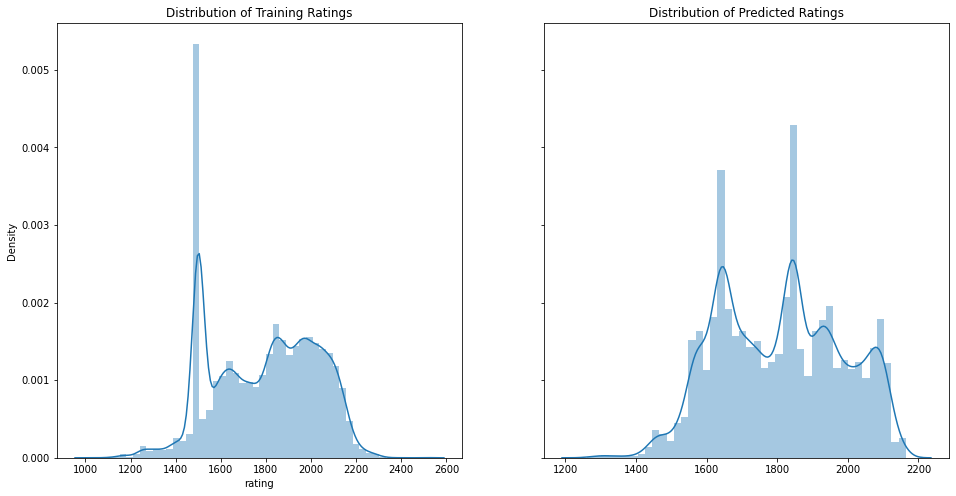

In [81]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
sns.distplot(y, ax=axs[0])
axs[0].set_title("Distribution of Training Ratings")
sns.distplot(final_preds , ax=axs[1])
axs[1].set_title("Distribution of Predicted Ratings")

In [68]:
X_test['rating'] = final_preds

In [73]:
X_test[['game_id', 'rating']].set_index('game_id')

,rating
game_id,
2,1969.660563
7,1920.516832
11,1758.877632
14,1842.553921
27,2083.719529
...,...
72760,2081.136412
72761,1655.437535
72762,1576.496911


In [74]:
X_test['rating'] = final_preds
submission = X_test[['game_id', 'rating']].set_index('game_id')

path_save = '/content/drive/MyDrive/머신러닝 엔지니어링/Kaggle/Scrabble Player Rating/submission/'
submission.to_csv(path_save + "LGBM_split_5.csv")

In [75]:
submission

,rating
game_id,
2,1969.660563
7,1920.516832
11,1758.877632
14,1842.553921
27,2083.719529
...,...
72760,2081.136412
72761,1655.437535
72762,1576.496911


In [65]:
submission

0        1969.660563
1        1920.516832
2        1758.877632
3        1842.553921
4        2083.719529
            ...     
22358    2081.136412
22359    1655.437535
22360    1576.496911
22361    2075.424889
22362    1850.494795
Name: rating, Length: 22363, dtype: float64